In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import requests
from io import StringIO

import os
import requests
import zipfile
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timedelta

# Getting coins sorted by volume DataFrame

In [4]:
url = "https://www.coinlore.com/ru/coins/all"

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)
coins = pd.read_html(StringIO(r.text))[0].dropna(how="all", axis=1).dropna(how="all", axis=0)
coins.set_index('#', inplace=True)
coins = coins[(coins['запас']!='0')]
coins["Ticker"] = coins["Название"].apply(lambda x: x.split(" ")[0]).to_list()
coins["Ticker"] = coins["Ticker"].apply(lambda x: str(x).strip()+"USDT")
coins.drop('Unnamed: 11', inplace=True, axis=1)
coins.columns = ['Name', 'Rate', 'Mcap', 'Volume', '24h Stock', 'Algorithm', 'Type', '24h', '7d', 'Ticker',]
coins.index = np.arange(coins.shape[0])
coins

Name        Rate     Mcap      Volume 24h Stock  \
0             BTC Bitcoin     $63,684    1.3 T  $28.1 млрд    19.8 M   
1            ETH Ethereum      $2,612  314.1 B    $11 млрд   120.2 M   
2        BNB Binance Coin     $574.03   95.7 B  $775.6 млн   166.8 M   
3              SOL Solana     $156.08   72.5 B   $2.2 млрд   464.7 M   
4           DOGE Dogecoin     $0.1188   17.4 B  $810.6 млн   146.2 B   
..                    ...         ...      ...         ...       ...   
618   MONK Monkey Project  $0.0000637      826          $0      13 M   
619  WBB Wild Beast Block    $0.00566      1 K          $0   181.9 K   
620        LUNA Luna Coin   $0.000637    1.1 K          $0     1.7 M   
621              XLQ ALQO  $0.0000263    1.5 K          $0    57.4 M   
622         CATO CatoCoin  $0.0000200    1.6 K          $0    82.3 M   

    Algorithm     Type     24h       7d    Ticker  
0      SHA256      PoW  -3.10%   -0.06%   BTCUSDT  
1      Ethash      PoW  -1.60%   -0.04%   ETHUSDT  
2         NaN      NaN  -3.96%   -3.45%   BNBUSDT  
3         NaN      PoS  -0.70%    6.88%   SOLUSDT  
4      Scrypt      PoW  -5.73%   11.14%  DOGEUSDT  
..        ...      ...     ...      ...       ...  
618       X11  PoW/PoS  -3.10%  -50.03%  MONKUSDT  
619    Scrypt      PoW   2.38%   -0.31%   WBBUSDT  
620       NaN      NaN  -3.10%   -0.05%  LUNAUSDT  
621     Quark  PoW/PoS  -0.88%  -98.95%   XLQUSDT  
622       NaN      NaN      0%   -9.92%  CATOUSDT  

[623 rows x 10 columns]

# Getting coins traded on Binance

In [6]:
from binance.client import Client

# Initialize Binance Client without keys for public data
client = Client()

# Fetch all symbol pairs
exchange_info = client.get_exchange_info()
symbols = [symbol['symbol'] for symbol in exchange_info['symbols']]

print(len(symbols))
# print(symbols)


2751


In [7]:
symbols_usdt = list(filter(lambda x: str(x).endswith('USDT'), symbols))
len(symbols_usdt)

519

# Extracting an intersection between existing coins and coins traded on Binance

In [9]:
coins_final = set(symbols)&set(coins['Ticker'])
len(coins_final)

118

In [10]:
coins_binance = coins[coins['Ticker'].isin(coins_final)]
coins_binance

Name        Rate     Mcap      Volume 24h Stock Algorithm  \
0           BTC Bitcoin     $63,684    1.3 T  $28.1 млрд    19.8 M    SHA256   
1          ETH Ethereum      $2,612  314.1 B    $11 млрд   120.2 M    Ethash   
2      BNB Binance Coin     $574.03   95.7 B  $775.6 млн   166.8 M       NaN   
3            SOL Solana     $156.08   72.5 B   $2.2 млрд   464.7 M       NaN   
4         DOGE Dogecoin     $0.1188   17.4 B  $810.6 млн   146.2 B    Scrypt   
..                  ...         ...      ...         ...       ...       ...   
438        ANC Anoncoin     $0.0318   67.2 K          $2     2.1 M       NaN   
469  COMP Compound Coin  $0.0000010   51.9 K          $0    53.7 B       X11   
553     SCRT SecretCoin    $0.00127    5.4 K          $0     4.2 M       X11   
557       SAGA SagaCoin   $0.000637    6.8 K          $0    10.7 M       NaN   
620      LUNA Luna Coin   $0.000637    1.1 K          $0     1.7 M       NaN   

        Type     24h       7d    Ticker  
0        PoW  -3.10%   -0.06%   BTCUSDT  
1        PoW  -1.60%   -0.04%   ETHUSDT  
2        NaN  -3.96%   -3.45%   BNBUSDT  
3        PoS  -0.70%    6.88%   SOLUSDT  
4        PoW  -5.73%   11.14%  DOGEUSDT  
..       ...     ...      ...       ...  
438      PoW  -1.13%  -20.68%   ANCUSDT  
469  PoW/PoS   1.13%   20.46%  COMPUSDT  
553  PoW/PoS  -3.10%   -0.05%  SCRTUSDT  
557      NaN  -3.10%   -0.05%  SAGAUSDT  
620      NaN  -3.10%   -0.05%  LUNAUSDT  

[118 rows x 10 columns]

In [11]:
def convert_to_number(value):
    # Remove any leading/trailing whitespaces
    value = value.strip()
    # Define multipliers for each suffix
    multipliers = {'T': 1_000_000_000_000, 'B': 1_000_000_000, 'M': 1_000_000, 'K': 1_000}
    # Extract the numeric part and the suffix
    if value[-1] in multipliers:
        # Multiply the number by the corresponding multiplier
        return float(value[:-2]) * multipliers[value[-1]]
    else:
        # Return the value as is if no recognized suffix is found
        return float(value)

# Apply the function to the Series
try:
    coins_binance.loc[:,'Mcap'] = coins_binance.loc[:,'Mcap'].apply(convert_to_number)
except:
    pass
coins_binance['Mcap'] = coins_binance['Mcap'].astype(float)
coins_binance = coins_binance.sort_values('Mcap', ascending=False)

coins_binance.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118 entries, 0 to 620
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       118 non-null    object 
 1   Rate       118 non-null    object 
 2   Mcap       118 non-null    float64
 3   Volume     118 non-null    object 
 4   24h Stock  118 non-null    object 
 5   Algorithm  29 non-null     object 
 6   Type       52 non-null     object 
 7   24h        118 non-null    object 
 8   7d         118 non-null    object 
 9   Ticker     118 non-null    object 
dtypes: float64(1), object(9)
memory usage: 9.7+ KB


C:\Users\Mikhail\AppData\Local\Temp\ipykernel_17872\1587748985.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coins_binance['Mcap'] = coins_binance['Mcap'].astype(float)


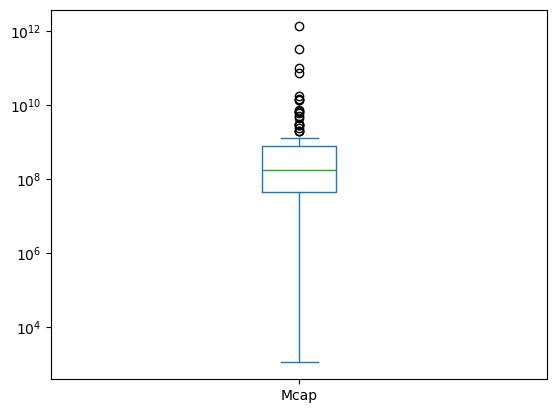

In [12]:
coins_binance['Mcap'].plot.box()
plt.yscale('log')

In [13]:
coins_binance.loc[:,'Mcap'].astype(float).describe()

count    1.180000e+02
mean     1.625387e+10
std      1.231034e+11
min      1.100000e+03
25%      4.402500e+07
50%      1.741500e+08
75%      7.733000e+08
max      1.300000e+12
Name: Mcap, dtype: float64

In [14]:
tickers = coins_binance[coins_binance['Mcap']<coins_binance['Mcap'].quantile(.75)]['Ticker'].to_list()
len(tickers)

88

In [15]:
print(*tickers)

CKBUSDT XTZUSDT MANAUSDT KLAYUSDT AXLUSDT ZECUSDT TFUELUSDT BTGUSDT IOTXUSDT OCEANUSDT GLMUSDT DYMUSDT HOTUSDT DASHUSDT ZRXUSDT ZILUSDT QTUMUSDT ANTUSDT SCUSDT RVNUSDT FLUXUSDT SKLUSDT BICOUSDT DCRUSDT ONEUSDT COTIUSDT ONTUSDT TRBUSDT XEMUSDT KDAUSDT CHRUSDT STORJUSDT ICXUSDT WAVESUSDT LSKUSDT XAIUSDT RLCUSDT DGBUSDT NANOUSDT CTSIUSDT CELRUSDT STEEMUSDT CYBERUSDT SYSUSDT ARKUSDT ARDRUSDT FRONTUSDT LOOMUSDT XVGUSDT ACAUSDT QKCUSDT DIAUSDT NKNUSDT BLZUSDT ZENUSDT LTOUSDT MFTUSDT AERGOUSDT VICUSDT NULSUSDT CTXCUSDT FISUSDT DNTUSDT WANUSDT KMDUSDT KEYUSDT FIOUSDT IRISUSDT VITEUSDT PIVXUSDT FIROUSDT MIRUSDT AEVOUSDT BTSUSDT BEAMUSDT STRAXUSDT REPUSDT JUPUSDT HCUSDT MEMEUSDT IQUSDT ANCUSDT NEBLUSDT COMPUSDT ACMUSDT SAGAUSDT SCRTUSDT LUNAUSDT


In [16]:
coins_binance[coins_binance['Ticker']=='CKBUSDT']

Name     Rate         Mcap     Volume 24h Stock Algorithm  \
32  CKB Nervos Network  $0.0169  756200000.0  $47.7 млн    44.7 B       NaN   

   Type     24h     7d   Ticker  
32  PoW  -5.35%  5.71%  CKBUSDT

In [17]:
# Base URL for Binance Vision spot data
BASE_URL = "https://data.binance.vision/data/spot/monthly/trades"

def generate_date_range(start_date, end_date):
    """
    Generate a list of (year, month) tuples from start_date to end_date.
    
    :param start_date: Start date in 'YYYY-MM-DD' format.
    :param end_date: End date in 'YYYY-MM-DD' format.
    :return: List of (year, month) tuples.
    """
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    date_list = []
    current = start
    while current <= end:
        date_list.append((current.year, current.month))
        current += timedelta(days=32)  # Move to the next month
        current = current.replace(day=1)  # Set day to 1
    
    return date_list

def download_and_extract_tick_trade_data(symbols, start_date, end_date, save_path='./', max_workers=5):
    """
    Download tick trade data from Binance Vision, extract it, and delete the zip files.
    
    :param symbols: List of trading symbols (e.g., ['ALICEUSDT', 'BTCUSDT'])
    :param start_date: Start date in 'YYYY-MM-DD' format.
    :param end_date: End date in 'YYYY-MM-DD' format.
    :param save_path: Directory to save the downloaded and extracted files.
    :param max_workers: Number of parallel workers for downloading.
    """
    # Ensure save path exists
    os.makedirs(save_path, exist_ok=True)
    
    # Generate the list of (year, month) tuples
    date_list = generate_date_range(start_date, end_date)
    
    # Function to download a single file
    def download_file(url, file_path):
        try:
            print(f"Downloading {os.path.basename(file_path)}...")
            response = requests.get(url, stream=True)
            response.raise_for_status()  # Raise an exception for HTTP errors
            
            # Save the content to a file
            with open(file_path, 'wb') as file:
                for chunk in response.iter_content(chunk_size=8192):
                    file.write(chunk)
            print(f"Downloaded {os.path.basename(file_path)} to {file_path}")
            return file_path
        except requests.exceptions.RequestException as e:
            print(f"Failed to download {os.path.basename(file_path)}: {e}")
            return None

    # Function to extract a zip file and delete it after extraction
    def extract_and_process_zip(file_path, extract_path):
        try:
            # Extract the zip file
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
                print(f"Extracted {os.path.basename(file_path)} to {extract_path}")
            
            # Process extracted files (example: listing the extracted files)
            for root, dirs, files in os.walk(extract_path):
                for file in files:
                    print(f"Processing file: {file}")
                    # Add your file processing code here (e.g., reading data from CSV)
            
            # Delete the zip file after extraction
            os.remove(file_path)
            print(f"Deleted {file_path}")
        except zipfile.BadZipFile as e:
            print(f"Failed to extract {os.path.basename(file_path)}: {e}")

    # Use ThreadPoolExecutor to download files in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        
        # Iterate over each symbol and date combination
        for symbol in symbols:
            for year, month in date_list:
                # Prepare the URL and filename
                file_name = f"{symbol}-trades-{year}-{month:02}.zip"
                url = f"{BASE_URL}/{symbol}/{file_name}"
                zip_file_path = os.path.join(save_path, file_name)
                
                # Submit download tasks
                futures.append(executor.submit(download_file, url, zip_file_path))
        
        # Process downloads as they complete
        for future in as_completed(futures):
            downloaded_file_path = future.result()
            if downloaded_file_path:
                # Extract and process the downloaded zip file
                extract_and_process_zip(downloaded_file_path, save_path)

# Example usage
if __name__ == "__main__":
    start_date = '2024-03-01'
    end_date = '2024-08-31'
    
    # Call the function to download and process data
    download_and_extract_tick_trade_data(tickers, start_date, end_date, save_path=r'D:\studying\masters\big_data\data', max_workers=30)


Downloaded AXLUSDT-trades-2024-08.zip to D:\studying\masters\big_data\data\AXLUSDT-trades-2024-08.zip
Downloaded XTZUSDT-trades-2024-05.zip to D:\studying\masters\big_data\data\XTZUSDT-trades-2024-05.zip
Downloaded MANAUSDT-trades-2024-07.zip to D:\studying\masters\big_data\data\MANAUSDT-trades-2024-07.zip
Downloaded MANAUSDT-trades-2024-08.zip to D:\studying\masters\big_data\data\MANAUSDT-trades-2024-08.zip
Extracted AXLUSDT-trades-2024-08.zip to D:\studying\masters\big_data\data
Processing file: KLAYUSDT-trades-2024-06.zip
Processing file: KLAYUSDT-trades-2024-07.zip
Processing file: KLAYUSDT-trades-2024-03.zip
Processing file: MANAUSDT-trades-2024-05.zip
Processing file: CKBUSDT-trades-2024-08.zip
Processing file: AXLUSDT-trades-2024-03.zip
Processing file: XTZUSDT-trades-2024-03.zip
Processing file: MANAUSDT-trades-2024-07.zip
Processing file: AXLUSDT-trades-2024-08.zip
Processing file: XTZUSDT-trades-2024-04.zip
Processing file: KLAYUSDT-trades-2024-08.zip
Processing file: XTZUSDT